The first step is to compose the training and testing datasets from historical data and computed technical analysis indicators. I will first work with a specific stock, symbol AI.PA

#### Let's download historical data for the last 20 years from Yahoo! API, and read it in a DataFrame:

In [39]:
!curl -L 'http://query1.finance.yahoo.com/v7/finance/download/AI.PA?period1=946857600&period2=1593820800&interval=1d&events=history' > historical_data_AI-PA.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     8  100     8    0     0     94      0 --:--:-- --:--:-- --:--:--    94
100  355k    0  355k    0     0  1157k      0 --:--:-- --:--:-- --:--:-- 1157k


In [40]:
# install required python packages
!pip install -r requirements.txt

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [135]:
# imports go here
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import ElasticNet
import sagemaker
import boto3

In [42]:
df = pd.read_csv('historical_data_AI-PA.csv', index_col=0, parse_dates=True, infer_datetime_format=True)

In [43]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,34.854301,36.306599,34.771301,35.061798,10.226519,904282.0
2000-01-04,35.061798,34.999500,32.613701,33.505798,9.772677,1381445.0
2000-01-05,32.779701,33.402100,32.281700,33.194599,9.681908,853763.0
2000-01-06,32.758900,36.223598,32.696701,35.580399,10.377778,1387137.0
2000-01-07,35.580399,37.136398,34.958000,35.144798,10.250728,2198233.0


In [44]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-29,126.099998,127.750000,125.699997,127.500000,127.500000,966640.0
2020-06-30,127.500000,128.399994,126.599998,128.399994,128.399994,1021045.0
2020-07-01,128.300003,129.350006,127.050003,128.449997,128.449997,684533.0
2020-07-02,129.600006,132.949997,128.800003,132.649994,132.649994,1304983.0
2020-07-03,132.000000,132.899994,129.800003,130.350006,130.350006,681232.0


#### Display descriptive stats about the dataset:

In [45]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5267.000000,5267.000000,5267.000000,5267.000000,5267.000000,5.267000e+03
mean,65.154315,65.766419,64.550407,65.181575,50.084645,1.257315e+06
std,26.437988,26.582026,26.277434,26.441206,31.948313,7.275060e+05
min,27.530800,28.087299,26.804600,26.970600,7.866548,0.000000e+00
25%,38.716299,39.138500,38.380001,38.770450,18.792883,8.208425e+05
50%,60.484501,61.058498,59.993599,60.505001,42.880104,1.094817e+06
75%,86.474750,87.168801,85.711201,86.457001,76.446960,1.493460e+06
max,140.500000,140.699997,139.800003,140.300003,137.140625,1.014686e+07


#### Plot the distributions of our features:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5610023b38>,
      dtype=object)

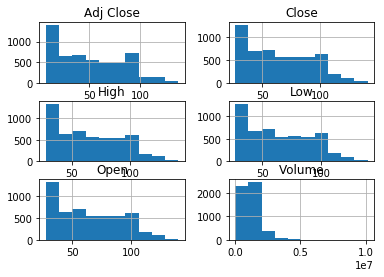

In [46]:
df.hist()

#### Are there any NaN values in the dataset?

In [47]:
df.isna().sum().sum()

30

#### Let's add technical analysis indicators to our feature set.  
I will use the 'ta' python package to compute them:

In [48]:
df = ta.add_all_ta_features(df, open='Open', high='High', low='Low', close='Close', volume='Volume')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [49]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,34.854301,36.306599,34.771301,35.061798,10.226519,904282.0,-5.620798e+05,904282.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-46.209035,NaN,0.000000
2000-01-04,35.061798,34.999500,32.613701,33.505798,9.772677,1381445.0,-9.104260e+05,-477163.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-4.437879,-4.539366,-4.437879
2000-01-05,32.779701,33.402100,32.281700,33.194599,9.681908,853763.0,-3.729013e+05,-1330926.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.928791,-0.933132,-5.325451
2000-01-06,32.758900,36.223598,32.696701,35.580399,10.377778,1387137.0,5.082923e+05,56211.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.187314,6.940771,1.479106
2000-01-07,35.580399,37.136398,34.958000,35.144798,10.250728,2198233.0,-1.312943e+06,-2142022.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.224272,-1.231828,0.236725


In [50]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'momentum_mfi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volume_vwap',
       'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ic

#### The dataset now has much more features, but also NaN values. I will then perform interpolation of the dataset, so that they get replaced by neutral values, i.e. that will not influence the algorithm during training:

In [51]:
df.isna().sum().sum()

33869

In [52]:
df.interpolate(axis=0, limit_direction='both', inplace=True)

In [53]:
df.isna().sum().sum()

0

#### I will now add historical data for CAC40 and SBF120, the indices that AI.PA stock relates to:

In [54]:
!curl -L 'http://query1.finance.yahoo.com/v7/finance/download/^FCHI?period1=946857600&period2=1593820800&interval=1d&events=history' > historical_data_CAC40.csv
!curl -L 'http://query1.finance.yahoo.com/v7/finance/download/^SBF120?period1=946857600&period2=1593820800&interval=1d&events=history' > historical_data_SBF120.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     8  100     8    0     0    258      0 --:--:-- --:--:-- --:--:--   258
100  404k    0  404k    0     0  1790k      0 --:--:-- --:--:-- --:--:-- 2561k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     8  100     8    0     0    242      0 --:--:-- --:--:-- --:--:--   242
100  339k    0  339k    0     0  1522k      0 --:--:-- --:--:-- --:--:-- 1522k


In [55]:
# Prefix columns with index name

cac40_df = pd.read_csv('historical_data_CAC40.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
sbf120_df = pd.read_csv('historical_data_SBF120.csv', index_col=0, parse_dates=True, infer_datetime_format=True)

# Drop 'Volume' and 'Adj Close' features, meaningless regarding market indices
cac40_df.drop(['Volume', 'Adj Close'], axis=1, inplace=True)
sbf120_df.drop(['Volume', 'Adj Close'], axis=1, inplace=True)

prefixed_cac_cols = list()
prefixed_sbf_cols = list()
for cac_col, sbf_col in zip(cac40_df.columns, sbf120_df.columns):
    prefixed_cac_cols.append('cac40_' + cac_col)
    prefixed_sbf_cols.append('sbf120_' + sbf_col)

cac40_df.columns = prefixed_cac_cols
sbf120_df.columns = prefixed_sbf_cols

In [56]:
# Check everything went as expected

print(cac40_df.head())
print('')
print(sbf120_df.head())

             cac40_Open   cac40_High    cac40_Low  cac40_Close
Date                                                          
2000-01-03  6024.379883  6102.120117  5901.770020  5917.370117
2000-01-04  5922.229980  5925.069824  5657.200195  5672.020020
2000-01-05  5521.830078  5589.500000  5461.589844  5479.700195
2000-01-06  5485.930176  5530.259766  5388.850098  5450.109863
2000-01-07  5423.879883  5561.689941  5423.879883  5539.609863

            sbf120_Open  sbf120_High   sbf120_Low  sbf120_Close
Date                                                           
2000-01-03  4035.110107  4035.110107  4035.110107   4035.110107
2000-01-04  3873.149902  3873.149902  3873.149902   3873.149902
2000-01-05  3743.870117  3743.870117  3743.870117   3743.870117
2000-01-06  3728.080078  3728.080078  3728.080078   3728.080078
2000-01-07  3794.070068  3794.070068  3794.070068   3794.070068


In [57]:
# Interpolate both dataframes to fill NaNs
cac40_df.interpolate(axis=0, limit_direction='both', inplace=True)
sbf120_df.interpolate(axis=0, limit_direction='both', inplace=True)

In [58]:
# Add These features to our stock price dataset
df = pd.concat([df, cac40_df], axis=1)

In [59]:
df = pd.concat([df, sbf120_df], axis=1)

In [60]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,others_dlr,others_cr,cac40_Open,cac40_High,cac40_Low,cac40_Close,sbf120_Open,sbf120_High,sbf120_Low,sbf120_Close
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,34.854301,36.306599,34.771301,35.061798,10.226519,904282.0,-5.620798e+05,904282.0,-0.402545,-833509.084988,...,-4.539366,0.000000,6024.379883,6102.120117,5901.770020,5917.370117,4035.110107,4035.110107,4035.110107,4035.110107
2000-01-04,35.061798,34.999500,32.613701,33.505798,9.772677,1381445.0,-9.104260e+05,-477163.0,-0.402545,-833509.084988,...,-4.539366,-4.437879,5922.229980,5925.069824,5657.200195,5672.020020,3873.149902,3873.149902,3873.149902,3873.149902
2000-01-05,32.779701,33.402100,32.281700,33.194599,9.681908,853763.0,-3.729013e+05,-1330926.0,-0.402545,-833509.084988,...,-0.933132,-5.325451,5521.830078,5589.500000,5461.589844,5479.700195,3743.870117,3743.870117,3743.870117,3743.870117
2000-01-06,32.758900,36.223598,32.696701,35.580399,10.377778,1387137.0,5.082923e+05,56211.0,-0.402545,-833509.084988,...,6.940771,1.479106,5485.930176,5530.259766,5388.850098,5450.109863,3728.080078,3728.080078,3728.080078,3728.080078
2000-01-07,35.580399,37.136398,34.958000,35.144798,10.250728,2198233.0,-1.312943e+06,-2142022.0,-0.402545,-833509.084988,...,-1.231828,0.236725,5423.879883,5561.689941,5423.879883,5539.609863,3794.070068,3794.070068,3794.070068,3794.070068


#### The value I am trying to predict is Ajdusted Close for day d + 1 to 7, from stock characteristics of day d. This means I have to shift the Adjusted Close column by -1 to -7, and drop the last 7 rows:

In [61]:
adjclose_df = pd.DataFrame()
adjclose_cols = list()
for i in range(1, 8):
    colname = 'AdjClose_D+' + str(i)
    adjclose_df[colname] = df['Adj Close'].shift(periods=-i)
    adjclose_cols.append(colname)
adjclose_df.columns = adjclose_cols

In [64]:
adjclose_df.tail(7)

,AdjClose_D+1,AdjClose_D+2,AdjClose_D+3,AdjClose_D+4,AdjClose_D+5,AdjClose_D+6,AdjClose_D+7
Date,,,,,,,
2020-06-25,126.099998,127.500000,128.399994,128.449997,132.649994,130.350006,NaN
2020-06-26,127.500000,128.399994,128.449997,132.649994,130.350006,NaN,NaN
2020-06-29,128.399994,128.449997,132.649994,130.350006,NaN,NaN,NaN
2020-06-30,128.449997,132.649994,130.350006,NaN,NaN,NaN,NaN
2020-07-01,132.649994,130.350006,NaN,NaN,NaN,NaN,NaN
2020-07-02,130.350006,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [65]:
adjclose_df.drop(adjclose_df.tail(i).index,inplace=True)

In [66]:
df.drop(df.tail(i).index,inplace=True)

In [67]:
adjclose_df.tail(7)

,AdjClose_D+1,AdjClose_D+2,AdjClose_D+3,AdjClose_D+4,AdjClose_D+5,AdjClose_D+6,AdjClose_D+7
Date,,,,,,,
2020-06-16,127.400002,126.550003,128.100006,127.349998,129.050003,126.199997,126.849998
2020-06-17,126.550003,128.100006,127.349998,129.050003,126.199997,126.849998,126.099998
2020-06-18,128.100006,127.349998,129.050003,126.199997,126.849998,126.099998,127.500000
2020-06-19,127.349998,129.050003,126.199997,126.849998,126.099998,127.500000,128.399994
2020-06-22,129.050003,126.199997,126.849998,126.099998,127.500000,128.399994,128.449997
2020-06-23,126.199997,126.849998,126.099998,127.500000,128.399994,128.449997,132.649994
2020-06-24,126.849998,126.099998,127.500000,128.399994,128.449997,132.649994,130.350006


In [68]:
adjclose_df.head()

,AdjClose_D+1,AdjClose_D+2,AdjClose_D+3,AdjClose_D+4,AdjClose_D+5,AdjClose_D+6,AdjClose_D+7
Date,,,,,,,
2000-01-03,9.772677,9.681908,10.377778,10.250728,9.893692,9.802925,9.916677
2000-01-04,9.681908,10.377778,10.250728,9.893692,9.802925,9.916677,10.147853
2000-01-05,10.377778,10.250728,9.893692,9.802925,9.916677,10.147853,10.371740
2000-01-06,10.250728,9.893692,9.802925,9.916677,10.147853,10.371740,10.026813
2000-01-07,9.893692,9.802925,9.916677,10.147853,10.371740,10.026813,9.923937


In [69]:
adjclose_df.shape

(5265, 7)

In [70]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,others_dlr,others_cr,cac40_Open,cac40_High,cac40_Low,cac40_Close,sbf120_Open,sbf120_High,sbf120_Low,sbf120_Close
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-18,127.150002,128.199997,125.449997,126.550003,126.550003,886472.0,2.255536e+08,246930822.0,0.187488,409308.773296,...,-0.669425,260.934151,4978.299805,5017.180176,4908.600098,4958.750000,3976.079515,3981.240028,3921.819399,3940.668816
2020-06-19,127.750000,129.350006,127.199997,128.100006,128.100006,2035713.0,2.252222e+08,248966535.0,0.147959,801601.985274,...,1.217375,265.354926,4997.529785,5040.470215,4979.450195,4979.450195,3976.365011,3981.530020,3922.057630,3940.923466
2020-06-22,127.400002,129.149994,127.000000,127.349998,127.349998,738802.0,2.247240e+08,248227733.0,0.105716,607929.214461,...,-0.587207,263.215823,4928.009766,5006.399902,4902.060059,4948.700195,3976.650507,3981.820011,3922.295861,3941.178117
2020-06-23,128.250000,129.500000,127.800003,129.050003,129.050003,984631.0,2.251873e+08,249212364.0,0.161753,760207.558560,...,1.326076,268.064419,4972.879883,5046.310059,4962.600098,5017.680176,3976.936003,3982.110002,3922.534092,3941.432767
2020-06-24,128.149994,128.300003,126.199997,126.199997,126.199997,861152.0,2.243262e+08,248351212.0,0.147496,300993.854921,...,-2.233202,259.935897,4985.629883,5004.040039,4871.359863,4871.359863,3977.221499,3982.399993,3922.772323,3941.687418


In [71]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,others_dlr,others_cr,cac40_Open,cac40_High,cac40_Low,cac40_Close,sbf120_Open,sbf120_High,sbf120_Low,sbf120_Close
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,34.854301,36.306599,34.771301,35.061798,10.226519,904282.0,-5.620798e+05,904282.0,-0.402545,-833509.084988,...,-4.539366,0.000000,6024.379883,6102.120117,5901.770020,5917.370117,4035.110107,4035.110107,4035.110107,4035.110107
2000-01-04,35.061798,34.999500,32.613701,33.505798,9.772677,1381445.0,-9.104260e+05,-477163.0,-0.402545,-833509.084988,...,-4.539366,-4.437879,5922.229980,5925.069824,5657.200195,5672.020020,3873.149902,3873.149902,3873.149902,3873.149902
2000-01-05,32.779701,33.402100,32.281700,33.194599,9.681908,853763.0,-3.729013e+05,-1330926.0,-0.402545,-833509.084988,...,-0.933132,-5.325451,5521.830078,5589.500000,5461.589844,5479.700195,3743.870117,3743.870117,3743.870117,3743.870117
2000-01-06,32.758900,36.223598,32.696701,35.580399,10.377778,1387137.0,5.082923e+05,56211.0,-0.402545,-833509.084988,...,6.940771,1.479106,5485.930176,5530.259766,5388.850098,5450.109863,3728.080078,3728.080078,3728.080078,3728.080078
2000-01-07,35.580399,37.136398,34.958000,35.144798,10.250728,2198233.0,-1.312943e+06,-2142022.0,-0.402545,-833509.084988,...,-1.231828,0.236725,5423.879883,5561.689941,5423.879883,5539.609863,3794.070068,3794.070068,3794.070068,3794.070068


In [72]:
df.shape

(5265, 86)

#### I will then train 7 models, each predicting a different Adjusted Close value for D + 1 up to 7:

#### The dataset has very different value ranges, so I have to normalize it:

In [73]:
X_scaler = MinMaxScaler().fit(df.values)
y_scaler = MinMaxScaler().fit(adjclose_df.values)

X_scaled = X_scaler.transform(df.values)
y_scaled = y_scaler.transform(adjclose_df.values)

#### Split training and testing sets:

In [139]:
# the last 20% data go to the testing set
train_size = int(len(X_scaled) * 0.80)
train_X, test_X = X_scaled[0:train_size], X_scaled[train_size:len(X_scaled)]
train_y, test_y = y_scaled[0:train_size], y_scaled[train_size:len(y_scaled)]

In [140]:
# Check if split is correct
print("training set size: {:.2f}%".format(len(train_X)/len(X_scaled) * 100))
print("testing set size: {:.2f}%".format(len(test_X)/len(X_scaled) * 100))

training set size: 80.00%
testing set size: 20.00%


#### Investigate by training models
I will then train several models including the DummyRegressor benchmark model, but also LinearRegressor and RandomForestRegressor, to get a better grasp of what model would be best suited for this use-case:

In [141]:
# This function returns the Root Mean Squared Error, normalized by Standard-Deviation
def sd_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.std(y_true)

# This one returns the Mean Absolute Percentage Error, normalized by the true values
# and expressed as a percentage
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_true, y_pred):
    print("\tMSE: {:.4f}".format(mean_squared_error(y_true, y_pred)))
    print("\tSD-RMSE: {:.4f}".format(sd_rmse(y_true, y_pred)))
    print("\tMAE: {:.4f}".format(mean_absolute_error(y_true, y_pred)))
    print("\tMAPE: {:.4f}%".format(mape(y_true, y_pred)))
    print("")

# Function that trains 7 models, each predicting
# adjusted close for day + 1 to 7
def train_eval(model_list, train_X, train_y, test_X, test_y):
    preds_list = list()
    for i in range(7):
        model_list[i].fit(train_X, train_y[:,i])
        preds_list.append(model_list[i].predict(test_X))
        print("Results for D+{}:".format(i + 1))
        print_metrics(test_y[:,i], preds_list[i])
    return preds_list

In [142]:
dummy_models_list = list()
for i in range(7):
    dummy_models_list.append(DummyRegressor())

dummy_preds_list = train_eval(dummy_models_list, train_X, train_y, test_X, test_y)

Results for D+1:
	MSE: 0.2097
	SD-RMSE: 4.2029
	MAE: 0.4448
	MAPE: 64.4343%

Results for D+2:
	MSE: 0.2100
	SD-RMSE: 4.2008
	MAE: 0.4451
	MAPE: 64.4350%

Results for D+3:
	MSE: 0.2103
	SD-RMSE: 4.1980
	MAE: 0.4453
	MAPE: 64.4361%

Results for D+4:
	MSE: 0.2105
	SD-RMSE: 4.1946
	MAE: 0.4456
	MAPE: 64.4371%

Results for D+5:
	MSE: 0.2108
	SD-RMSE: 4.1916
	MAE: 0.4459
	MAPE: 64.4387%

Results for D+6:
	MSE: 0.2111
	SD-RMSE: 4.1856
	MAE: 0.4462
	MAPE: 64.4400%

Results for D+7:
	MSE: 0.2114
	SD-RMSE: 4.1812
	MAE: 0.4465
	MAPE: 64.4410%



In [143]:
linear_models_list = list()
for i in range(7):
    linear_models_list.append(LinearRegression())

linear_preds_list = train_eval(linear_models_list, train_X, train_y, test_X, test_y)

Results for D+1:
	MSE: 0.0004
	SD-RMSE: 0.1783
	MAE: 0.0153
	MAPE: 2.1647%

Results for D+2:
	MSE: 0.0008
	SD-RMSE: 0.2553
	MAE: 0.0222
	MAPE: 3.1426%

Results for D+3:
	MSE: 0.0016
	SD-RMSE: 0.3660
	MAE: 0.0329
	MAPE: 4.6350%

Results for D+4:
	MSE: 0.0014
	SD-RMSE: 0.3382
	MAE: 0.0292
	MAPE: 4.1310%

Results for D+5:
	MSE: 0.0012
	SD-RMSE: 0.3166
	MAE: 0.0261
	MAPE: 3.7238%

Results for D+6:
	MSE: 0.0013
	SD-RMSE: 0.3274
	MAE: 0.0265
	MAPE: 3.7894%

Results for D+7:
	MSE: 0.0013
	SD-RMSE: 0.3256
	MAE: 0.0257
	MAPE: 3.6879%



In [144]:
rf_models_list = list()
for i in range(7):
    rf_models_list.append(RandomForestRegressor(n_estimators=100, random_state=42))

rf_preds_list = train_eval(rf_models_list, train_X, train_y, test_X, test_y)

Results for D+1:
	MSE: 0.0101
	SD-RMSE: 0.9243
	MAE: 0.0595
	MAPE: 7.4187%

Results for D+2:
	MSE: 0.0116
	SD-RMSE: 0.9883
	MAE: 0.0661
	MAPE: 8.3114%

Results for D+3:
	MSE: 0.0117
	SD-RMSE: 0.9896
	MAE: 0.0696
	MAPE: 8.8473%

Results for D+4:
	MSE: 0.0122
	SD-RMSE: 1.0090
	MAE: 0.0753
	MAPE: 9.7072%

Results for D+5:
	MSE: 0.0130
	SD-RMSE: 1.0418
	MAE: 0.0772
	MAPE: 9.9316%

Results for D+6:
	MSE: 0.0136
	SD-RMSE: 1.0637
	MAE: 0.0792
	MAPE: 10.1883%

Results for D+7:
	MSE: 0.0143
	SD-RMSE: 1.0884
	MAE: 0.0803
	MAPE: 10.3016%



As the dataset is relatively small (approx. 4000 records) and contains a lot of features (approx. 90), I would have expected LinearRegression model to perform poorly, and RandomForestRegressor to shine, but the linear models obtained suprisingly good evaluation metrics, versus quite poor accuracy for the random forests!

Let's investigate further by training:
- a simple model working with distances like K-Nearest-Neighbors
- Kernel Ridge, another simple model
- a more complex model like Support Vector Machines

In [145]:
knn_models_list = list()
for i in range(7):
    knn_models_list.append(KNeighborsRegressor())

knn_preds_list = train_eval(knn_models_list, train_X, train_y, test_X, test_y)

Results for D+1:
	MSE: 0.0119
	SD-RMSE: 1.0000
	MAE: 0.0762
	MAPE: 10.0277%

Results for D+2:
	MSE: 0.0122
	SD-RMSE: 1.0139
	MAE: 0.0775
	MAPE: 10.1985%

Results for D+3:
	MSE: 0.0125
	SD-RMSE: 1.0230
	MAE: 0.0787
	MAPE: 10.3614%

Results for D+4:
	MSE: 0.0128
	SD-RMSE: 1.0337
	MAE: 0.0797
	MAPE: 10.4862%

Results for D+5:
	MSE: 0.0131
	SD-RMSE: 1.0456
	MAE: 0.0809
	MAPE: 10.6409%

Results for D+6:
	MSE: 0.0133
	SD-RMSE: 1.0516
	MAE: 0.0815
	MAPE: 10.7036%

Results for D+7:
	MSE: 0.0136
	SD-RMSE: 1.0592
	MAE: 0.0824
	MAPE: 10.8164%



KNN does quite poorly at predicting the values I am interested in, most probably because of the large number of features the dataset has.

In [146]:
svr_models_list = list()
for i in range(7):
    svr_models_list.append(SVR(gamma='auto'))

svr_preds_list = train_eval(svr_models_list, train_X, train_y, test_X, test_y)

Results for D+1:
	MSE: 0.0169
	SD-RMSE: 1.1924
	MAE: 0.1225
	MAPE: 17.4810%

Results for D+2:
	MSE: 0.0162
	SD-RMSE: 1.1670
	MAE: 0.1195
	MAPE: 17.0088%

Results for D+3:
	MSE: 0.0154
	SD-RMSE: 1.1344
	MAE: 0.1157
	MAPE: 16.4371%

Results for D+4:
	MSE: 0.0147
	SD-RMSE: 1.1072
	MAE: 0.1127
	MAPE: 15.9876%

Results for D+5:
	MSE: 0.0134
	SD-RMSE: 1.0569
	MAE: 0.1073
	MAPE: 15.2103%

Results for D+6:
	MSE: 0.0127
	SD-RMSE: 1.0273
	MAE: 0.1040
	MAPE: 14.7014%

Results for D+7:
	MSE: 0.0126
	SD-RMSE: 1.0212
	MAE: 0.1034
	MAPE: 14.5998%



In [147]:
kr_models_list = list()
for i in range(7):
    kr_models_list.append(KernelRidge())

kr_preds_list = train_eval(kr_models_list, train_X, train_y, test_X, test_y)

Results for D+1:
	MSE: 0.0005
	SD-RMSE: 0.2098
	MAE: 0.0198
	MAPE: 2.8160%

Results for D+2:
	MSE: 0.0007
	SD-RMSE: 0.2347
	MAE: 0.0218
	MAPE: 3.1036%

Results for D+3:
	MSE: 0.0008
	SD-RMSE: 0.2586
	MAE: 0.0239
	MAPE: 3.3942%

Results for D+4:
	MSE: 0.0010
	SD-RMSE: 0.2838
	MAE: 0.0261
	MAPE: 3.6948%

Results for D+5:
	MSE: 0.0011
	SD-RMSE: 0.3066
	MAE: 0.0280
	MAPE: 3.9598%

Results for D+6:
	MSE: 0.0013
	SD-RMSE: 0.3267
	MAE: 0.0296
	MAPE: 4.1611%

Results for D+7:
	MSE: 0.0014
	SD-RMSE: 0.3450
	MAE: 0.0311
	MAPE: 4.3634%



It is interesting to note that a complex model like Support Vector Regressor fails to obtain good predictions, and that only simple models like Kernel Ridge and Linear Regression work well with the dataset.

#### DeepAR

The last algorithm I willtrain before moving to dimensionality reduction is DeepAR. It is included in Amazon SageMaker, and is supposed to work very well with time-oriented data such as the market dataset I am working on. It is implemented with a Recurrent Neural Network.

In [148]:
# Initialize SageMaker and S3 variables
sagemaker_session = sagemaker.Session()
s3_bucket = sagemaker.Session().default_bucket()
s3_prefix = 'deepar-stock-pred'
role = sagemaker.get_execution_role()
region = sagemaker_session.boto_region_name
s3_output_path = "s3://{}/{}/output".format(s3_bucket, s3_prefix)
image_name = sagemaker.amazon.amazon_estimator.get_image_uri(region, "forecasting-deepar", "latest")

In [151]:
# split the test set into validation and testing set for DeepAR
# the first 50% of the testing set go to the validation set
valid_size = int(len(test_X) * 0.5)
valid_X, test_X = test_X[0:valid_size], test_X[valid_size:len(test_X)]
valid_y, test_y = test_y[0:valid_size], test_y[valid_size:len(test_y)]

In [152]:
# Check if split is correct
print("validation set size: {}".format(len(valid_X)))
print("testing set size: {}".format(len(test_X)))

validation set size: 526
testing set size: 527


In [150]:
# Convert datasets to DeepAR JSON format and write them to local files
train_X_dict = {"start": str(df.index[0]), "target": adjclose_df['AdjClose_D+1'].to_list()}
train_X_json = json.dumps(train_X_dict)

train_
train_y_json = 

train_local_file = 'train.json'
test_local_file = 'test.json'

SyntaxError: invalid syntax (<ipython-input-150-86226e75bc0f>, line 5)

In [ ]:
# Upload dataset to S3 to make it available to SageMaker
s3_data_path = "s3://{}/{}/data".format(s3_bucket, s3_prefix)
s3 = boto3.resource('s3')
bucket = s3.Bucket(s3_bucket)
with open(train_local_file, 'rb') as data:
    bucket.put_object(Key=s3_data_path + "/" + train_local_file, Body=data)

with open(test_local_file, 'rb') as data:
    bucket.put_object(Key=s3_data_path + "/" + test_local_file, Body=data)

In [ ]:
estimator = sagemaker.estimator.Estimator(
    sagemaker_session=sagemaker_session,
    image_name=image_name,
    role=role,
    train_instance_count=1,
    train_instance_type='ml.p2.xlarge',
    base_job_name='deepar-stock-pred-job',
    output_path=s3_output_path
)

# Use 1 day frequency for the time series
freq = '1D'

# Predict for 7 days
prediction_length = 7